In [2]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import itertools
import random

In [3]:
faraday_constant = 96485.33212 * (coulomb/mole)

#taken from Gerstner
g_bar_nmda = 1.5*nsiemens
tau_d = 40*ms
tau_r = 3*ms
beta = 1/(3.57*mM)
alpha = 0.062*(1/mV)
M = 1.2*mM
tau_ampa = 5*ms
g_bar_ampa = 1.5*nsiemens
V_rest = -65*mV

#arbitrary values for demonstration purposes
g_bar_leak = 0.25*usiemens
n_ampa_channels_start = 50

#Calcium Hypothesis threshholds, explanation see below
thresh_a = 0.000030*pmole
thresh_b = 0.000075*pmole
n_discount = 1/1000

#Basic equation for the RC-Model of the Postsynaptic membrane.
#g_leak, g_nmda and g_ampa are summed values from the (two) synapses that connect to the membrane
eqs = '''
    #model voltage @ soma, neglecting dendritic tree
    dV/dt = ( I(t) - ( (g_leak*(V-V_rest) + (g_nmda*(V-0*mV)) + (g_ampa*(V-0*mV)) ) ) ) / nfarad : volt
    g_ampa : siemens
    g_nmda : siemens
    g_leak : siemens
    
    '''

#Equations for the synapses. Models derived from Gerstner Book (see proof provided elsewhere).
synapse_eqs = '''
    dq/dt = (-q/tau_d) + (-q/tau_r) : 1 (clock-driven)
    dr/dt = (-r/tau_d) + (q/tau_r) : 1 (clock-driven)
    g_nmda_syn = g_bar_nmda * r * g_inf : siemens
    g_inf = 1/ (1 + beta*exp(-alpha*V)*M) : 1
    g_nmda_post = g_nmda_syn : siemens (summed)

    #ampa eqs from gerstner
    dx/dt = -x/tau_ampa : 1 (clock-driven)
    g_ampa_syn = g_bar_ampa * x : siemens

    g_leak_syn = g_bar_leak : siemens
    g_leak_post = g_leak_syn : siemens (summed)

    #Model Ca2+ concentration at different postsynapses
    # 7 per cent of ions traveling through nmda channels are Ca2+ (Koch)
    # we naively infer the concentration of Ca2+ ions traveling through the channel as follows:
    # we observe that we can infer the amount of [elementary charges] traveling through the channel per t by dividing the conductance by faradays constant
    # we make the assumption that the elementary charges pertain only to Ca2+, K+ and Na+. Of the total amount of [Ions] ([Ca2+] + [K+] + [Na+]), 7 per cent
    # are Ca2+ ions which carry two positive charges. Therefore, [elementary charges] = 2*0.07*[Ions] + 0.93*[Ions] = 1.07*[Ions]
    # ie. [Ions] = [elementary charges]/1.07
    # We calculate [Ca2+] = 0.07*[Ions] = ([elementary charges]/1.07)*0.07 = [elementary charges] * (0.07/1.07)
    # (0.07/1.07) is roughly 0.0654
    # Also Calcium may leak through leakage channels or dissappears otherwise, here we just make up numbers for demonstration purposes
    # We multiply by 5000 to augment numbers (also for demonstration purposes)
    dCa/dt = ( 0.0654*( -(5000*g_nmda_syn*(V-0*mV))/faraday_constant ) - 0.00001*pmole/ms * sign(Ca) ): mole (clock-driven)
    dn_syn/dt = ( (0 + int(Ca >= thresh_a)*(-1) + int(Ca >= thresh_b)*(2.5))*int(n_syn >= 0) + int(n_syn < 0) ) / ms : 1 (clock-driven)

    g_ampa_post = (n_syn*n_discount)*g_ampa_syn : siemens (summed)


    '''

###################
#Utility Functions#
###################

def solve(eqs, synapse_eqs, total_run, pre, post, V_start=-65*mV):
    #Run a brian2 model for the given total_run time, with presynaptic spikes (pre) and postsynaptic spikes (post)
    #Postsynaptic spikes are used for demonstrating Hebb learning below
    #pre contains a list of spike times for each connecting synapse
    #post is a list of tuples. Each tuple defines (onset, length, current strength)

    #convert post into a TimedArray for brian2
    time_array = [0*nA]*(int(total_run/ms))
    for (pot, length, cur) in post:
        time_array[int(pot/ms):int(pot/ms) + int(length/ms)] = [cur]*int(length/ms)
    I = TimedArray(time_array, dt=ms)

    #convert pre in a SpikeGeneratorGroup for brian2
    syns = list(itertools.chain.from_iterable( [len(x)*[i] for i, x in enumerate(pre)] ))
    Inp = SpikeGeneratorGroup(2, syns, list(itertools.chain.from_iterable(pre))) #pre

    #create brian2 model, we have one postsynaptic membrane and connecting synapses
    #observables are set to their starting values
    G = NeuronGroup(1, eqs, method = "euler")

    G.V = V_start

    S = Synapses(Inp, G, synapse_eqs, on_pre='''q += 1
                                                x += 1''', method = "euler")

    S.connect(i = [0, 1], j = [0, 0])

    S.q = 0
    S.r = 0
    S.x = 0
    S.n_syn = n_ampa_channels_start


    #create monitors for the observables
    mon_1 = StateMonitor(G, ['V'], record=True)

    # dirty hack to muffle the statemonitor's screams
    # statemonitor is unhappy because it thinks that there could be multiple postsynaptic membranes
    # and synapse connections might change. This would apparently make it hard to monitor the g_nmda_syn variable
    # since this variable depends on V, which pertains to the postsynaptic membrane.
    # We trick brian2 into believing that the indeces cannot change, and that works
    S.variables['_postsynaptic_idx'].__class__ = core.variables.ArrayVariable
    mon_2 = StateMonitor(S, ['Ca', 'g_nmda_syn', 'n_syn', 'g_ampa_syn'], record=True)
    S.variables['_postsynaptic_idx'].__class__ = core.variables.DynamicArrayVariable


    run(total_run)
    return (mon_1.V.T, [i.g_nmda_syn.T for i in mon_2], mon_1.t, [i.Ca.T for i in mon_2], 
            [i.n_syn.T for i in mon_2], [i.g_ampa_syn.T for i in mon_2])


#plot utility function used below
def plot_nmda(total_run, pre, post, plot_ampa = False, g_scale = [0*psiemens, 300*psiemens], Ca_scale = [0*pmole, 0.0008*pmole], show_plot = True,
                figure_size = (6.4, 4.8), plot_ns = False, plot_synapses = [0], colors2 = colormaps["Dark2"], colors1 = colormaps["Set1"], color_offset=1):
    
    #total_run, pre, post are used for the brian2 model in solve()
    #rest of the variable names is descriptive, we have different scales for the plots of the observables, as well as some
    #booleans encoding what to plot, a colormap and other matplotlib arguments

    #run the model so we can plot
    Vs, gs, ts, Ca, ns, g_amps = solve(eqs, synapse_eqs, total_run, pre, post)

    #see if we want to plot the number of ampa channels for each synapse
    if not plot_ns:
        fig, axs = plt.subplots(3, figsize=figure_size)
    else:
        fig, axs = plt.subplots(4, figsize=figure_size)

    #init axes for matplotlib plot
    max_lim = np.max(ns)

    axs[0].set_ylim(g_scale)
    axs[0].set_ylabel("Conductance")
    axs[1].set_ylim([-80*mV, 0*mV])
    axs[1].set_ylabel("Membrane\n Voltage")
    axs[2].set_ylim(Ca_scale)
    axs[2].set_ylabel("Postsynaptic Ca2+\n Concentration")
    if plot_ns:
        axs[3].set_ylim([0, max_lim])
        axs[3].set_ylabel("# AMPA channels")

    #plot observables
    axs[1].plot(ts, Vs)

    for i in plot_synapses:
        axs[0].plot(ts, gs[i], color = colors1(i+color_offset), label="g_nmda syn. " + str(i))
        if plot_ampa:
            axs[0].plot(ts, g_amps[i], color = colors2(i+color_offset), label = "g_ampa syn. " + str(i))
        
        axs[2].plot(ts, Ca[i], color = colors1(i+color_offset), label="[Ca2+] syn. " + str(i))

        if plot_ns:
            axs[3].plot(ts, ns[i], color = colors1(i+color_offset), label="n syn. " + str(i))
    
    #insert lines at post/ pre spike times
    if post:
        for axis in axs:
            axis.vlines(x=np.array(post)[:,0], ymin = -200, ymax=max_lim, color='red', linestyles="dashed", alpha = 0.4, label = "post")

    if pre:
        for axis in axs:
            for i, syn_ in enumerate(pre):
                if syn_ != []:
                    axis.vlines(x=syn_, ymin = -200, ymax=max_lim, color=colormaps["Pastel2"](i), alpha = 0.66, label = "pre syn. " + str(i))

    axs[0].legend()

    if show_plot:
        plt.show()

    return Vs, gs, ts, Ca, ns, g_amps



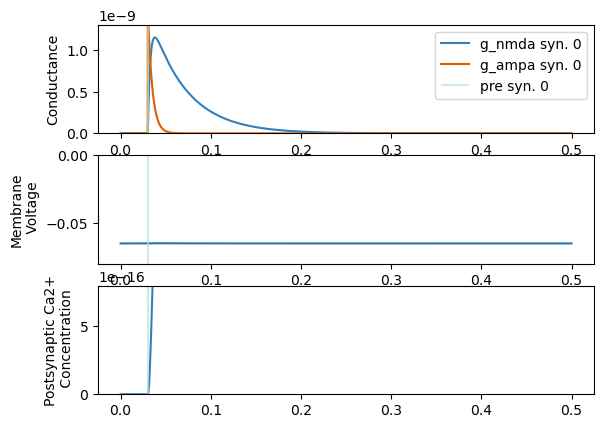

In [4]:
#First we will reproduce the behavior of the nmda channel at one synapse as described in the gerstner book in fig. 3.2.
#For this we set the magnesium concentration to 0 and ignore the ampa channels
M = 0*mM
n_ampa_channels_start = 0

total_run = 500*ms

pre =   [
            [30*ms],
            []
        ]
post = []

_,_,_,_,_,_ = plot_nmda(total_run, pre, post, plot_ampa = True, g_scale = [0*usiemens, 1.3*nsiemens])

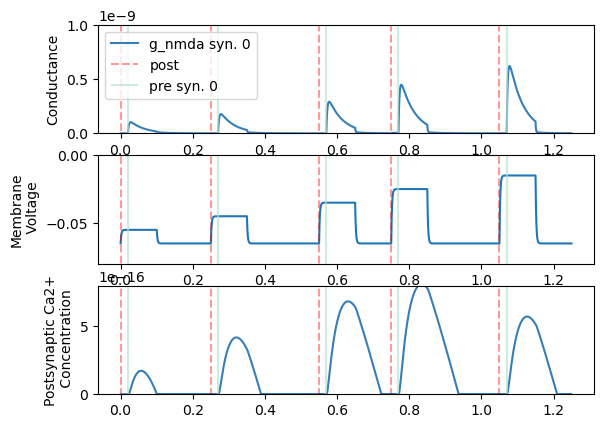

In [5]:
#Next, we will examine the voltage dependence of the nmda channels (again only at one synapse)
#For this, we have to increase the magnesium concentration.
#Then we send spikes at certain times at which we artificially depolarize the postsynaptic membrane
#to differing degrees and observe the opening (=conductance) of the nmda channels
M = 1.2*mM

total_run = 1250*ms

pre =   [
            [20*ms, 270*ms, 570*ms, 770*ms, 1070*ms],
            []
        ]
post = [(0*ms, 100*ms, 5*nA), (250*ms, 100*ms, 10*nA), (550*ms, 100*ms, 15*nA), (750*ms, 100*ms, 20*nA), (1050*ms, 100*ms, 25*nA)]

_,_,_,_,_,_ = plot_nmda(total_run, pre, post, g_scale = [0*usiemens, 1*nsiemens])

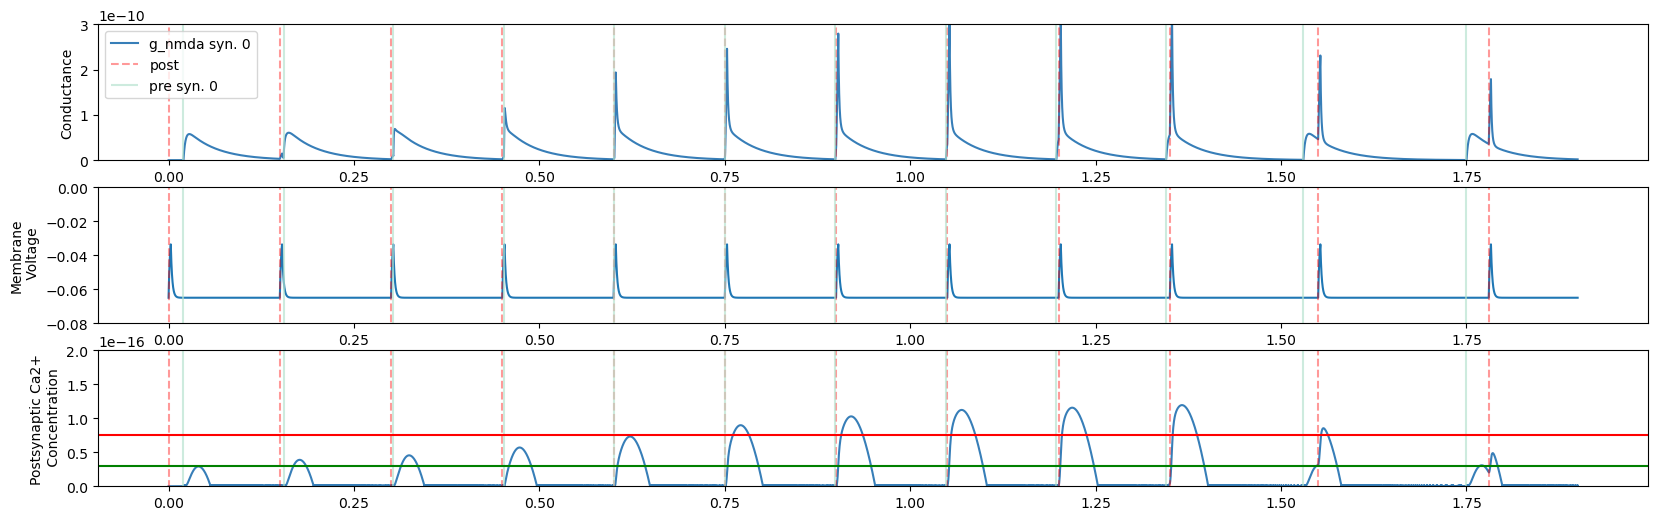

In [6]:
#Now we will illustrate the coincidence detection implemented by these nmda channels
#For this we observe scenarios where the is a short post-spike (which we just simulate as a short, strong current at the postsynaptic membrane)
#long before, just before, incidentally, just after, long after a presynaptic spike

total_run = 1900*ms

pre =   [
            [20*ms, 155*ms, 303*ms, 452*ms, 601*ms, 750*ms, 899*ms, 1048*ms, 1197*ms, 1345*ms, 1530*ms, 1750*ms],
            []
        ]
post = [(0*ms, 3*ms, 20*nA), (150*ms, 3*ms, 20*nA), (300*ms, 3*ms, 20*nA), (450*ms, 3*ms, 20*nA), (600*ms, 3*ms, 20*nA), (750*ms, 3*ms, 20*nA),
        (900*ms, 3*ms, 20*nA), (1050*ms, 3*ms, 20*nA), (1200*ms, 3*ms, 20*nA), (1350*ms, 3*ms, 20*nA), (1550*ms, 3*ms, 20*nA), (1780*ms, 3*ms, 20*nA)]

_,_,_,_,_,_ = plot_nmda(total_run, pre, post, Ca_scale = [0*pmole, 0.0002*pmole], show_plot = False, figure_size = (20, 6))

plt.gcf().get_axes()[2].axhline(y=0.000000000000000075, color = "red")
plt.gcf().get_axes()[2].axhline(y=0.000000000000000030, color = "green")
plt.show()



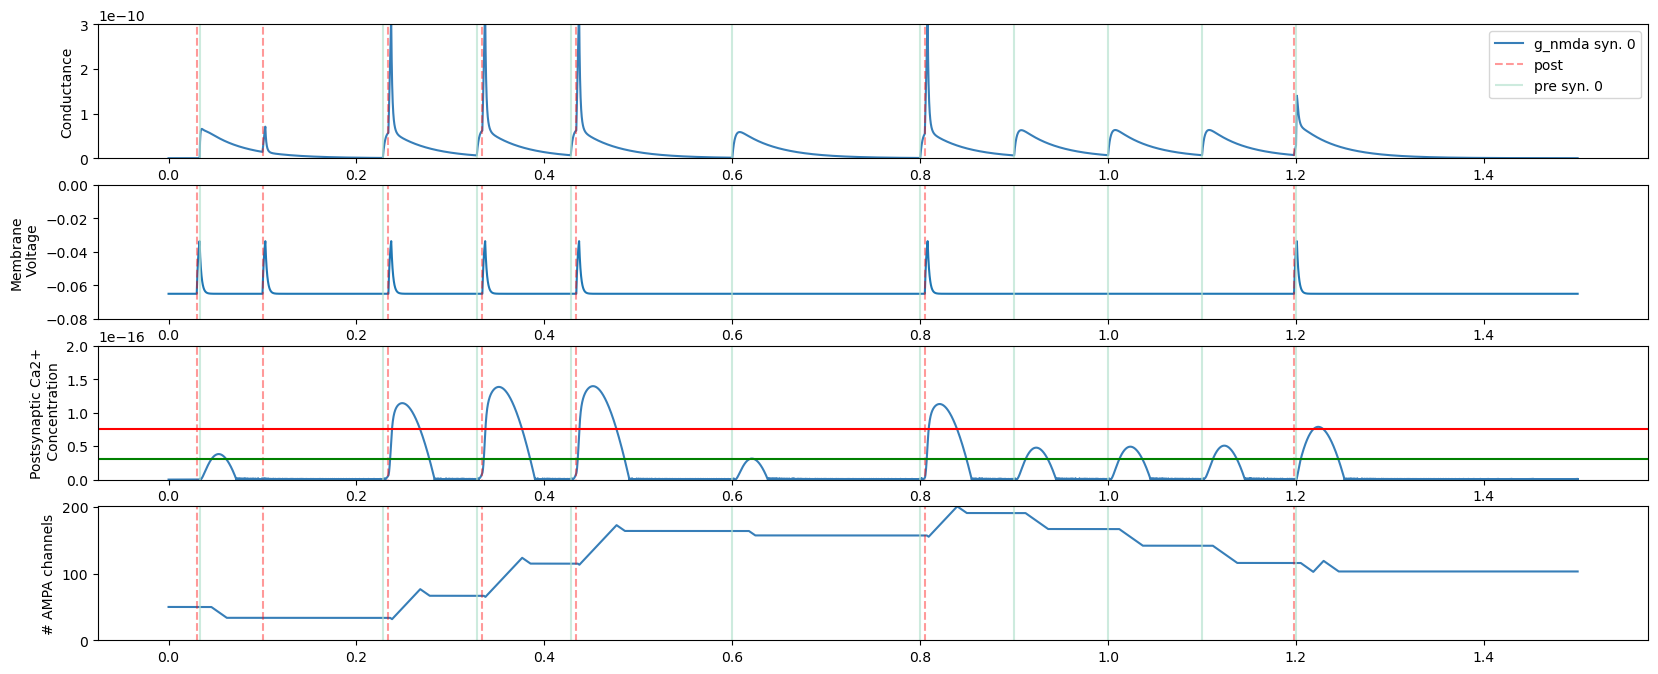

In [7]:
#The behavior of the postsynaptic Ca2+ concentration in the experiment above already hints at the implementation of
#spike time dependent plasticity through the Calcium Hypothesis
#To further illustrate this, we will now plot the development of the number of ampa channels throughout some
#series of differently timed pre/post spikes
n_ampa_channels_start = 50


total_run = 1500*ms

pre =   [
            [33*ms, 228*ms, 328*ms, 428*ms, 600*ms, 800*ms, 900*ms, 1000*ms, 1100*ms, 1200*ms],
            []
        ]
post = [(30*ms, 3*ms, 20*nA), (100*ms, 3*ms, 20*nA), (234*ms, 3*ms, 20*nA), (334*ms, 3*ms, 20*nA), (434*ms, 3*ms, 20*nA), (805*ms, 3*ms, 20*nA), (1198*ms, 3*ms, 20*nA)]

_,_,ts,_,ns,_ = plot_nmda(total_run, pre, post, Ca_scale = [0*pmole, 0.0002*pmole], show_plot = False, figure_size = (20, 8), plot_ns = True)
plt.gcf().get_axes()[2].axhline(y=0.000000000000000075, color = "red") #0.000075*pmole
plt.gcf().get_axes()[2].axhline(y=0.000000000000000030, color = "green") #0.00003*pmole
plt.show()




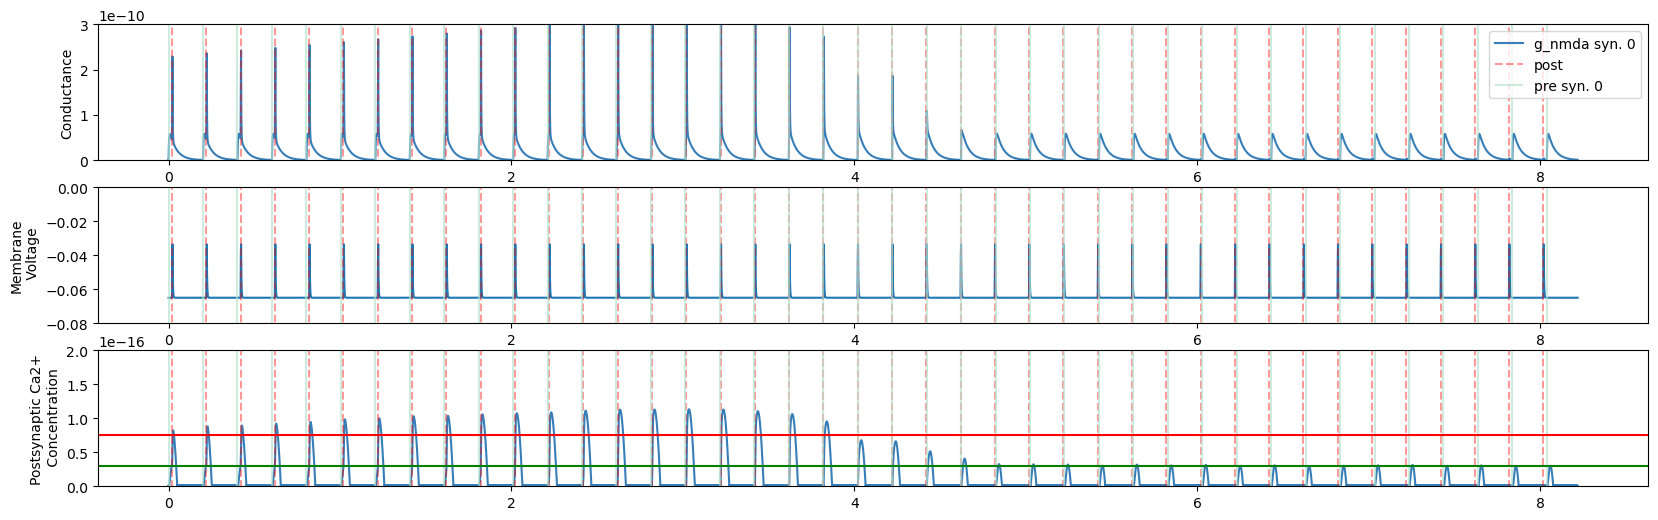

In [8]:
#We do essentially the same as above, but now more coordinated, because we want to plot the development of ampa channels (ie. plasticity)
#relative to the offset between pre- and postsynaptic spikes
g_bar_ampa = 0*nsiemens
n_ampa_channels_start = 50

sims = 20

def create_post_array(times_):
    return [(i, 3*ms, 20*nA) for i in times_]

post_times = np.arange(0,2*sims+1)*200*ms+sims*ms
post = create_post_array(post_times)

pre = [[p+(i*ms) for i, p in enumerate(post_times, start=-sims)],[]]

total_run = post_times[-1] + 200*ms


_,_,ts,_,ns,_ = plot_nmda(total_run, pre, post, Ca_scale = [0*pmole, 0.0002*pmole], show_plot = False, figure_size = (20, 6))
plt.gcf().get_axes()[2].axhline(y=0.000000000000000075, color = "red") #0.000075*pmole
plt.gcf().get_axes()[2].axhline(y=0.000000000000000030, color = "green") #0.00003*pmole
plt.show()

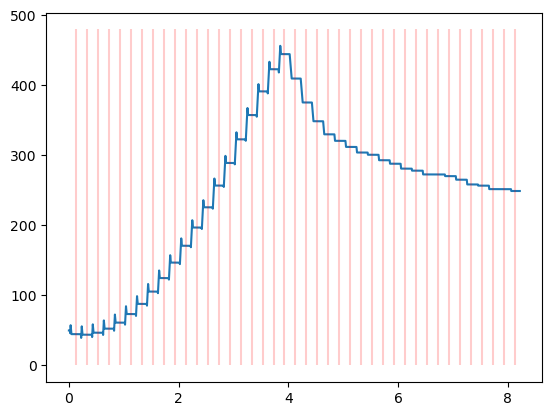

In [9]:
#plot the development of the number of ampa channels

ns = ns[0]

plt.plot(ts, ns)

#red lines, see below
times_ = np.arange(0,2*sims+1)*200*ms+130*ms

plt.vlines(x=times_, ymin = 0, ymax=480, color='red', alpha = 0.2)

plt.show()

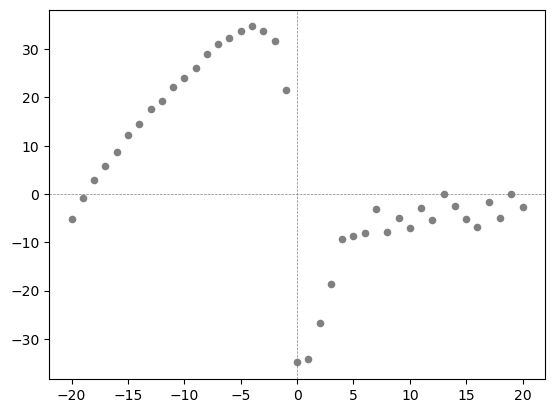

In [10]:
#in the figure above, we are interested in how the number of ampa channels changes between each respective offset,
#ie. we want to find the height differences of the blue line at two successive intersections with the red lines.
#The red lines are more or less arbitrarily placed between the different stimulations, where the number of ampa channels
#is expected to be stable


#round times_ to closest values in ts:
rounded_indices = [0]
cur = 0

for ind, t_ in enumerate(list(ts)):
    if t_ >= times_[cur]:
        rounded_indices.append(ind)
        cur += 1
        if cur >= len(times_):
            break

#compute the deltas between the values
deltas = np.array([cur-prev for prev, cur in zip(ns[rounded_indices], ns[rounded_indices][1:])]).flatten()

range_ = range(-sims, sims+1)
plt.scatter(range_, deltas, marker='o', s=20, c="grey")
plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')
plt.axvline(0, color='gray', linewidth=0.5, linestyle='--')
plt.show()

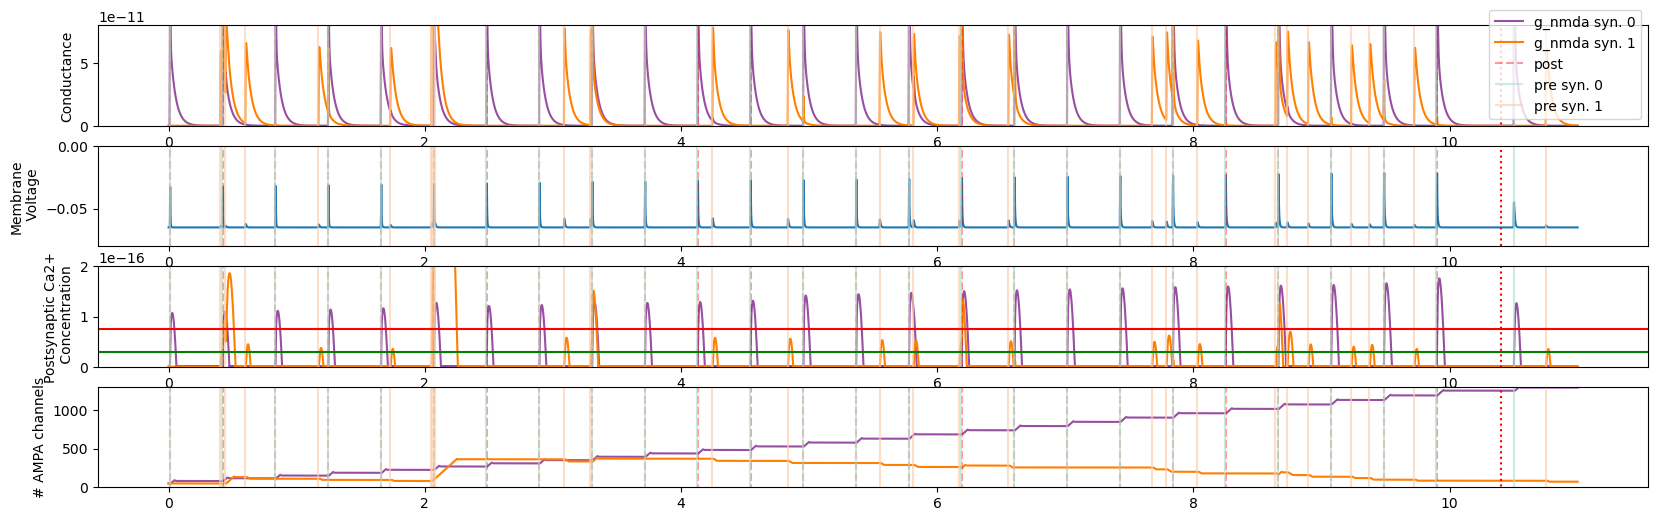

In [11]:
# Finally, we will show how the synapse may learn an association via Hebb learning.
# For this, we compare two synaptic connections, one who is firing incidently to postsynaptic depolarization, and one who is firing at random.

g_bar_ampa = 1.5*nsiemens
n_ampa_channels_start = 50
M = 1.2*mM
n_discount = 1/5

random.seed("<3")

total_run = 11000*ms
spike_number = 25

def create_post_array(times_):
    return [(i, 3*ms, 20*nA) for i in times_]

post_times = np.linspace(10,(total_run-1100*ms)/ms,spike_number)
post = create_post_array(post_times*ms)

pre = [
        np.concatenate(((post_times - 2), [total_run/ms - 500]))*ms,
        np.concatenate((random.sample(range(int(total_run/ms-1100)), spike_number), [total_run/ms - 250]))*ms
      ]

_,_,ts,_,ns,_ = plot_nmda(total_run, pre, post, Ca_scale = [0*pmole, 0.0002*pmole], show_plot = False, figure_size = (20, 6), plot_synapses=[0,1], color_offset=3, g_scale = [0*usiemens, 0.08*nsiemens], plot_ns = True)
plt.gcf().get_axes()[2].axhline(y=0.000000000000000075, color = "red") #0.000075*pmole
plt.gcf().get_axes()[2].axhline(y=0.000000000000000030, color = "green") #0.00003*pmole

for axs in plt.gcf().get_axes():
    axs.vlines(x=10400*ms, ymin = -200, ymax=2000, color="red", linestyles="dotted")

plt.show()